# OrgaTuring: AI Deciphers Organoids towards Futurizing Healthcare 

- CNN with Interpretability Pipeline to localize, quantize, and classify Organoid Inflamed and Non-Inflamed images

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:XLA_CPU:0 || Unnamed device || XLA_CPU || 16.0 GiB
 /device:XLA_GPU:0 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:1 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:2 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:3 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:GPU:0 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:1 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:2 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:3 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB


2022-09-28 18:18:22.534680: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-28 18:18:22.569304: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3499710000 Hz
2022-09-28 18:18:22.570517: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5599a49d86e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-28 18:18:22.570538: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-28 18:18:22.573715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-28 18:18:24.628687: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5599a4a6c3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-28 18:18:24.628738: I tensor

In [3]:
#import packages
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
import splitfolders
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
import sklearn

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')


In [4]:
IMG_SIZE = 224
BATCH = 64
SEED = 42
GPUS = ["GPU:0", "GPU:1", "GPU:2","GPU:3"]

In [5]:
strategy = tf.distribute.MirroredStrategy(GPUS)
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


2022-09-28 18:18:27.522374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-28 18:18:27.524257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-28 18:18:27.525482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-28 18:18:27.526682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:82:00.0 n

In [6]:
batch_size = BATCH * strategy.num_replicas_in_sync

In [7]:
print(batch_size)

256


- Splitting the Dataset into train, test, and valid

In [8]:
# # Creating Train, Test, and Valid Dataset
# input_folder = "../../../aman/Updated_Dataset_2D/Sorted/"


In [9]:
# # Split with a ratio.

# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# # Train, val, test
# splitfolders.ratio(input_folder, output="./dataset/", 
#                    seed=42, ratio=(.7, .2, .1), 
#                    group_prefix=None) # default values

In [4]:
train_dir = os.path.join("./dataset/raw_dataset/train/")
valid_dir = os.path.join('./dataset/raw_dataset/val/')
test_dir = os.path.join('./dataset/raw_dataset/test/')

train_i_dir = os.path.join('./dataset/raw_dataset/train/Inflamed/')
train_ni_dir = os.path.join('./dataset/raw_dataset/train/NonInflamed/')

valid_i_dir = os.path.join('./dataset/raw_dataset/val/Inflamed/')
valid_ni_dir = os.path.join('./dataset/raw_dataset/val/NonInflamed')

test_i_dir = os.path.join('./dataset/raw_dataset/test/Inflamed/')
test_ni_dir = os.path.join('./dataset/raw_dataset/test/NonInflamed')

In [7]:
train_i_names = os.listdir(train_i_dir)
len(train_i_names)

train_ni_names  = os.listdir(train_ni_dir)
print(train_ni_names [:10])

valid_i_names = os.listdir(valid_i_dir)
print(valid_i_names[:10])

valid_ni_names = os.listdir(valid_ni_dir)
print(valid_ni_names[:10])

test_i_names = os.listdir(test_i_dir)
print(test_i_names[:10])

test_ni_names = os.listdir(test_ni_dir)
print(test_ni_names[:10])

['CD11-LC-NI P12 190905 4x.tif', 'CD24-I-NI P1 190620 4X.tif', 'CD50-I-NI P4 200304 10X.JPG', 'CD27-R-NI P3 190711 10X.tif', 'CD19-LC-NI P6 191002 10X 1.tif', 'CD50-R p3 191210 4X.tif', 'CD12-Il-NI_QS_2474.tif', 'CD21-I-NI P2 190813 10X.tif', 'CD12 ILEUM NI 4.tif', 'CD47-C-NI P0 191004 10X.tif']
['CD11 IL-I-QS_2498 20x 190603.tif', 'CD62-I-I P1 202026 10X.JPG', 'CD41-I-I P2 190909 10x .tif', 'CD11 IL-I-QS_2500 40x 190603.tif', 'CD63-I-I P3 200318 4X.JPG', 'CD11 IL-I-QS_2497 20x 190603.tif', 'CD42-I-I P2 190920 4X.tif', 'CD62-I-I P2 200304 10X.JPG', 'CD11 IL-I-QS_2494 10x 190603.tif']
['CD30-LC-NI P13 191003 10X 1.tif', 'CD13-LC-NI_QS_2482.tif', 'CD62-R-NI P1 10x 02.23.20.JPG', 'CD12 IL-NI-QS_2512 40x 190603.tif', 'CD47-I-NI P0 191007 10X.tif', 'CD32-I p9 10x 9-19-19.tif', 'CD62-R-NI P0 200219 10X.JPG', 'CD30-LC-NI P1 190715 4X.tif', 'CD13-LC-NI P4 190602 4x.tif', 'CD63-LC-NI P3 200309 4X.JPG']
['CD11 IL-I-QS_2499 20x 190603.tif', 'CD11 ILEUM Inf 3.tif', 'CD11-I-I P8 190719 4X.tif', 'CD

In [160]:
print('total training i images:', len(os.listdir(train_i_dir)))
print('total training ni images:', len(os.listdir(train_ni_dir)))
print('total validation i images:', len(os.listdir(valid_i_dir)))
print('total validation ni images:', len(os.listdir(valid_ni_dir)))
print('total testing i images:', len(os.listdir(test_i_dir)))
print('total testing ni images:', len(os.listdir(test_ni_dir)))

num_train_i =  len(os.listdir(train_i_dir))
num_train_ni =  len(os.listdir(train_ni_dir))
num_val_i =  len(os.listdir(valid_i_dir))
num_val_ni =  len(os.listdir(valid_ni_dir))
num_test_i =  len(os.listdir(test_i_dir))
num_test_ni =  len(os.listdir(test_ni_dir))

total_train =num_train_i  + num_train_ni
total_val = num_val_i  + num_val_ni
total_test = num_test_i   + num_test_ni 

print("-----------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

total training i images: 34
total training ni images: 251
total validation i images: 9
total validation ni images: 71
total testing i images: 6
total testing ni images: 37
-----------------------------------------------------
Total training images: 285
Total validation images: 80
Total testing images: 43


In [161]:
train_i = glob.glob(train_i_dir+"/*.*")
train_ni = glob.glob(train_ni_dir+"/*.*")
# train_i_names

In [162]:
valid_i = glob.glob(valid_i_dir+"/*.*")
valid_ni = glob.glob(valid_ni_dir+"/*.*")
# train_i_names

In [163]:
test_i = glob.glob(test_i_dir+"/*.*")
test_ni = glob.glob(test_ni_dir+"/*.*")
# train_i_names

In [164]:
train_list = [x for x in train_i]
train_list.extend([x for x in train_ni])

df_train = pd.DataFrame(np.concatenate([['Inflamed']*len(train_i) , ['NonInflamed']*len(train_ni)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [165]:
valid_list = [x for x in valid_i]
valid_list.extend([x for x in valid_ni])

df_valid = pd.DataFrame(np.concatenate([['Inflamed']*len(valid_i) , ['NonInflamed']*len(valid_ni)]), columns = ['class'])
df_valid['image'] = [x for x in valid_list]

In [166]:
test_list = [x for x in test_i]
test_list.extend([x for x in test_ni])

df_test = pd.DataFrame(np.concatenate([['Inflamed']*len(test_i) , ['NonInflamed']*len(test_ni)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [167]:
df_train

,class,image
0,Inflamed,./dataset/train/Inflamed/CD 11 ILEUM.tif
1,Inflamed,./dataset/train/Inflamed/CD11-Il-I_QS_2471.tif
2,Inflamed,./dataset/train/Inflamed/CD42-I-I P0 190905 4x .tif
3,Inflamed,./dataset/train/Inflamed/CD11-Il-I_QS_2470.tif
4,Inflamed,./dataset/train/Inflamed/CD42-I-I P5 191002 10X.tif
...,...,...
280,NonInflamed,./dataset/train/NonInflamed/CD63-LC-NI P4 200316 10X.JPG
281,NonInflamed,./dataset/train/NonInflamed/CD47-LC-NI P2 191017 4x.tif
282,NonInflamed,./dataset/train/NonInflamed/CD26-LC-NI P3 191114 10X.tif
283,NonInflamed,./dataset/train/NonInflamed/CD32-I-NI P0 190722 10X.tif


In [168]:
class_i = df_train[df_train['class'] == 'Inflamed']
class_ni = df_train[df_train['class'] == 'NonInflamed']


In [169]:
class_i

,class,image
0,Inflamed,./dataset/train/Inflamed/CD 11 ILEUM.tif
1,Inflamed,./dataset/train/Inflamed/CD11-Il-I_QS_2471.tif
2,Inflamed,./dataset/train/Inflamed/CD42-I-I P0 190905 4x .tif
3,Inflamed,./dataset/train/Inflamed/CD11-Il-I_QS_2470.tif
4,Inflamed,./dataset/train/Inflamed/CD42-I-I P5 191002 10X.tif
5,Inflamed,./dataset/train/Inflamed/CD12-LC-I_QS_2472.tif
6,Inflamed,./dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603.tif
7,Inflamed,./dataset/train/Inflamed/CD41-I-I P2 190909 4x .tif
8,Inflamed,./dataset/train/Inflamed/CD11 IL-I-QS_2503 40x 190603.tif
9,Inflamed,./dataset/train/Inflamed/CD13-Il-I_QS_2477.tif


In [170]:
class_ni

,class,image
34,NonInflamed,./dataset/train/NonInflamed/CD11-LC-NI P12 190905 4x.tif
35,NonInflamed,./dataset/train/NonInflamed/CD24-I-NI P1 190620 4X.tif
36,NonInflamed,./dataset/train/NonInflamed/CD50-I-NI P4 200304 10X.JPG
37,NonInflamed,./dataset/train/NonInflamed/CD27-R-NI P3 190711 10X.tif
38,NonInflamed,./dataset/train/NonInflamed/CD19-LC-NI P6 191002 10X 1.tif
...,...,...
280,NonInflamed,./dataset/train/NonInflamed/CD63-LC-NI P4 200316 10X.JPG
281,NonInflamed,./dataset/train/NonInflamed/CD47-LC-NI P2 191017 4x.tif
282,NonInflamed,./dataset/train/NonInflamed/CD26-LC-NI P3 191114 10X.tif
283,NonInflamed,./dataset/train/NonInflamed/CD32-I-NI P0 190722 10X.tif


In [171]:
# Convert parts into NumPy arrays for weight computation
i_numpy = class_i['class'].to_numpy()
ni_numpy = class_ni['class'].to_numpy()


In [172]:
all_together = np.concatenate((i_numpy, ni_numpy))
unique_classes = np.unique(all_together)

In [173]:
# weights = class_weight.compute_class_weight('balanced', unique_classes, all_together)
# print(weights)

In [174]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(all_together), y = all_together )

In [175]:
class_weights = dict(enumerate(class_weights))

In [176]:
class_weights

{0: 4.1911764705882355, 1: 0.5677290836653387}

In [177]:
df_valid

,class,image
0,Inflamed,./dataset/val/Inflamed/CD11 IL-I-QS_2498 20x 190603.tif
1,Inflamed,./dataset/val/Inflamed/CD62-I-I P1 202026 10X.JPG
2,Inflamed,./dataset/val/Inflamed/CD41-I-I P2 190909 10x .tif
3,Inflamed,./dataset/val/Inflamed/CD11 IL-I-QS_2500 40x 190603.tif
4,Inflamed,./dataset/val/Inflamed/CD63-I-I P3 200318 4X.JPG
...,...,...
75,NonInflamed,./dataset/val/NonInflamed/CD47-I-NI P2 191024 10X.tif
76,NonInflamed,./dataset/val/NonInflamed/CD42-R p3 9.14.19 4x.tif
77,NonInflamed,./dataset/val/NonInflamed/CD59-R-NI P0 191212 4X.tif
78,NonInflamed,./dataset/val/NonInflamed/CD24-RC-NI P2 190628 4X.tif


In [178]:
df_test

,class,image
0,Inflamed,./dataset/test/Inflamed/CD11 IL-I-QS_2499 20x 190603.tif
1,Inflamed,./dataset/test/Inflamed/CD11 ILEUM Inf 3.tif
2,Inflamed,./dataset/test/Inflamed/CD11-I-I P8 190719 4X.tif
3,Inflamed,./dataset/test/Inflamed/CD62-I-I P2 200304 4X.JPG
4,Inflamed,./dataset/test/Inflamed/CD11 ILEUM Inf 2.tif
5,Inflamed,./dataset/test/Inflamed/CD11 IL-I-QS_2493 10x 190603.tif
6,NonInflamed,./dataset/test/NonInflamed/CD12 IL-NI-QS_2505 20x 190603.tif
7,NonInflamed,./dataset/test/NonInflamed/CD50-R-NI P0 191119 4X.tif
8,NonInflamed,./dataset/test/NonInflamed/CD62-R-NI P1 5x 02.23.20.JPG
9,NonInflamed,./dataset/test/NonInflamed/CD60-LC-NI P0 10x 01.17.19.JPG


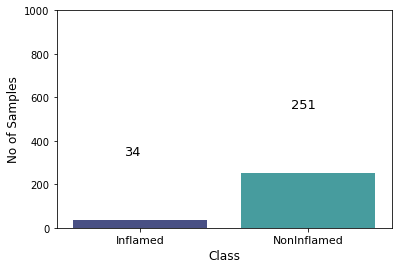

In [179]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("No of Samples", fontsize= 12)
plt.ylim(0,1000)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

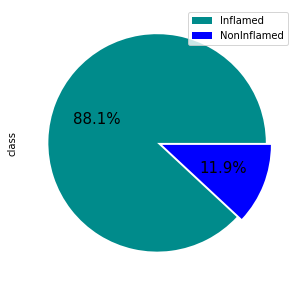

In [180]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

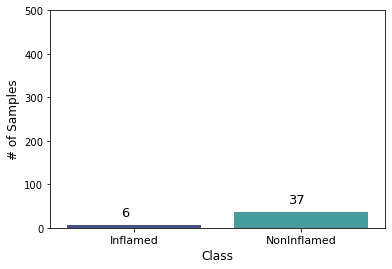

In [181]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

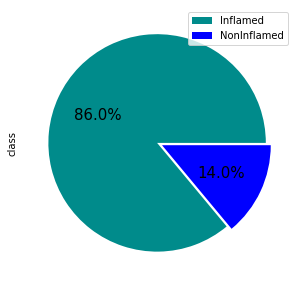

In [182]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

Train Set - Inflamed


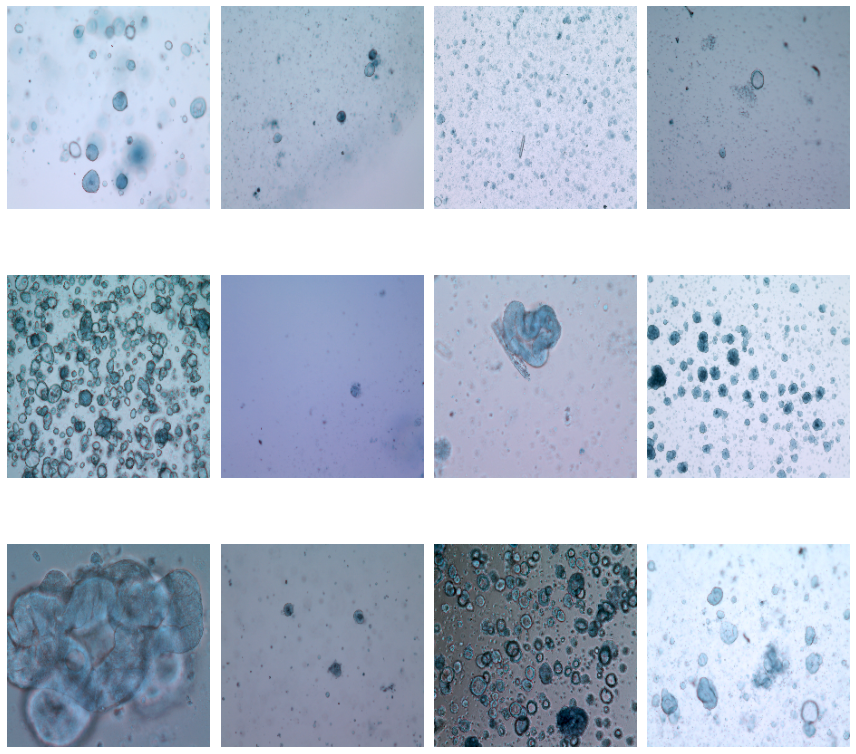

In [183]:
print('Train Set - Inflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_i[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - NonInflamed


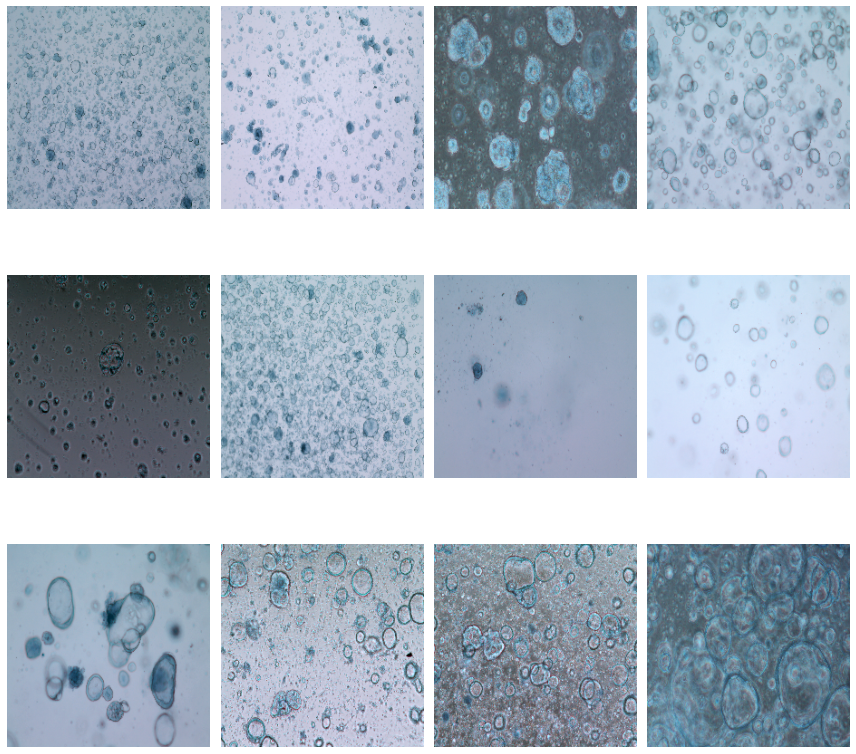

In [184]:
print('Train Set - NonInflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_ni[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [231]:
# train_datagen = ImageDataGenerator(rescale=1/255.)
train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        vertical_flip= True,
        fill_mode = 'reflect',
        brightness_range=[0.2,1.2])

valid_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale = 1/255.)

In [186]:
ds_train = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'Inflamed': 0., 'NonInflamed': 1.}
                                                 )

Found 285 images belonging to 2 classes.


In [187]:
ds_valid = valid_datagen.flow_from_directory(valid_dir,
                                                 target_size = (224, 224),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'Inflamed': 0., 'NonInflamed': 1.}
                                                 )

Found 80 images belonging to 2 classes.


In [235]:

ds_test = test_datagen.flow_from_directory(test_dir ,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            shuffle=False,
                                            classes={'Inflamed': 0., 'NonInflamed': 1.}
                                            )

Found 43 images belonging to 2 classes.


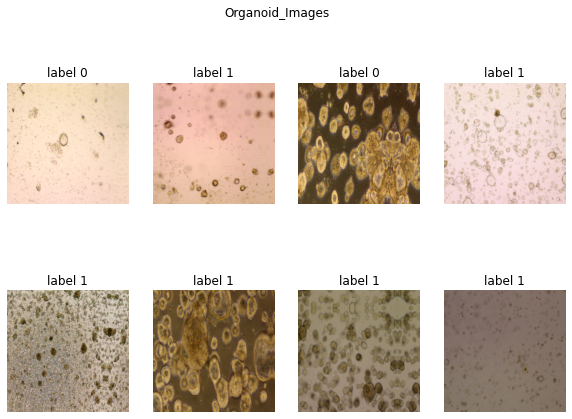

In [188]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("Organoid_Images")
for k in range(8):
    images, labels = ds_train.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [189]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (224, 224, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [190]:
checkpoint_path = "./checkpoint_path/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [191]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [192]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_1/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [193]:
# Training the CNN on the Training set and evaluating it on the Test set
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,patience=2, min_lr=0.0000001)


history = model_vgg19.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=100, 
        shuffle=True, 
        verbose=True,
        callbacks=[cp_callback, checkpoint,reduce_lr],
        class_weight = class_weights,
        )

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 9.0414 - acc: 0.4561 
Epoch 00001: saving model to ./checkpoint_path/training_1/cp.ckpt
5/5 [==============================] - 17s 3s/step - loss: 9.0414 - acc: 0.4561 - val_loss: 2.8037 - val_acc: 0.8875 - lr: 0.0100
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 8.5915 - acc: 0.8000 
Epoch 00002: saving model to ./checkpoint_path/training_1/cp.ckpt
5/5 [==============================] - 17s 3s/step - loss: 8.5915 - acc: 0.8000 - val_loss: 10.6333 - val_acc: 0.1125 - lr: 0.0100
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 5.1113 - acc: 0.2175
Epoch 00003: saving model to ./checkpoint_path/training_1/cp.ckpt
5/5 [==============================] - 17s 3s/step - loss: 5.1113 - acc: 0.2175 - val_loss: 1.0312 - val_acc: 0.8875 - lr: 0.0100
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 3.3088 - acc: 0.7228
Epoch 00004: saving model to ./checkpoint_path/training_1

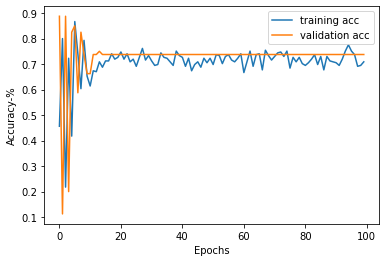

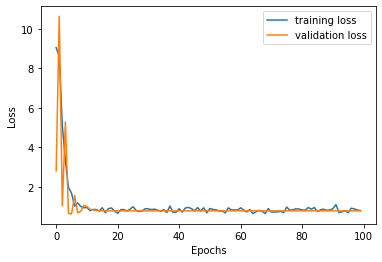

In [194]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)


In [216]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [217]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [224]:
checkpoint_path = "./checkpoint_path/training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [225]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [226]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_2/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [221]:
#Setting callbakcs

# early_stopping = callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     min_delta=1e-7,
#     restore_best_weights=True,
# )

# plateau = callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor = 0.2,                                     
#     patience = 2,                                   
#     min_delt = 1e-7,                                
#     cooldown = 0,                               
#     verbose = 1
# ) 

In [227]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 200,
          validation_data=ds_valid,
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/200
5/4 [=================================] - ETA: -1s - loss: 0.3240 - binary_accuracy: 0.8596
Epoch 00001: saving model to ./checkpoint_path/training_3/cp.ckpt
5/4 [=================================] - 17s 3s/step - loss: 0.3240 - binary_accuracy: 0.8596 - val_loss: 0.4442 - val_binary_accuracy: 0.8125
Epoch 2/200
5/4 [=================================] - ETA: -1s - loss: 0.3047 - binary_accuracy: 0.8702
Epoch 00002: saving model to ./checkpoint_path/training_3/cp.ckpt
5/4 [=================================] - 21s 4s/step - loss: 0.3047 - binary_accuracy: 0.8702 - val_loss: 0.4414 - val_binary_accuracy: 0.8125
Epoch 3/200
5/4 [=================================] - ETA: -1s - loss: 0.3544 - binary_accuracy: 0.8772
Epoch 00003: saving model to ./checkpoint_path/training_3/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.3544 - binary_accuracy: 0.8772 - val_loss: 0.4528 - val_binary_accuracy: 0.8125
Epoch 4/200
5/4 [=================================] - ETA:

In [241]:
model_pretrained.evaluate(ds_test) #validation#

43/43 [==============================] - 3s 61ms/step - loss: 0.2528 - binary_accuracy: 0.9302


[0.25276386737823486, 0.930232584476471]

In [236]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25276386737823486
Test accuracy: 0.930232584476471


In [239]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [240]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 4,731,137
Non-trainable params: 53,862,912
_________________________________________

In [242]:
checkpoint_path = "./checkpoint_path/training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [243]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [244]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_2/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [245]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_valid,
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/50
5/4 [=================================] - ETA: -1s - loss: 0.4009 - binary_accuracy: 0.8281
Epoch 00001: saving model to ./checkpoint_path/training_4/cp.ckpt
5/4 [=================================] - 19s 4s/step - loss: 0.4009 - binary_accuracy: 0.8281 - val_loss: 0.4007 - val_binary_accuracy: 0.8250
Epoch 2/50
5/4 [=================================] - ETA: -1s - loss: 0.4847 - binary_accuracy: 0.8281
Epoch 00002: saving model to ./checkpoint_path/training_4/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.4847 - binary_accuracy: 0.8281 - val_loss: 0.4069 - val_binary_accuracy: 0.8125
Epoch 3/50
5/4 [=================================] - ETA: -1s - loss: 0.5404 - binary_accuracy: 0.8175
Epoch 00003: saving model to ./checkpoint_path/training_4/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.5404 - binary_accuracy: 0.8175 - val_loss: 0.4184 - val_binary_accuracy: 0.8125
Epoch 4/50
5/4 [=================================] - ETA: -1s